# Linear scan voltammetry (LSV)
Peter Attia, April 18 2020

This notebook plots the first lithiation of carbon black electrodes as a function of sweep rate.

In [1]:
import re
import glob
from pathlib import Path

import numpy as np
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Load data

In [3]:
file_list = sorted(list((Path.cwd()).glob('*.txt')))
file_list

[PosixPath('/Users/peter/Desktop/first cycle/LSV/cellE_CB_LSV_3mVpermin_CB1.txt'),
 PosixPath('/Users/peter/Desktop/first cycle/LSV/cellF_CB_LSV_10mVpermin_CB2.txt'),
 PosixPath('/Users/peter/Desktop/first cycle/LSV/cellG_CB_LSV_30mVpermin_CB3.txt'),
 PosixPath('/Users/peter/Desktop/first cycle/LSV/cellH_CB_LSV_100mVpermin_CB4.txt'),
 PosixPath('/Users/peter/Desktop/first cycle/LSV/cellI_CB_LSV_300mVpermin_CB5.txt')]

In [4]:
masses = [1.0, 1.0, 1.0, 1.0, 1.0] # mg. Measured via analytical microbalance

#### Sanity check dVdt values

3 -3.000445268594945 0.6090303352423291 -0.20297998487655372
10 -10.002255003113708 0.5378946798955853 -0.0537773411823772
30 -29.939482586270127 1.5046745942106194 -0.05025720100121718
100 -100.02010430021092 0.6232664014496389 -0.006231411232874754
300 -300.05609981459264 0.7598870161055383 -0.002532483147568336


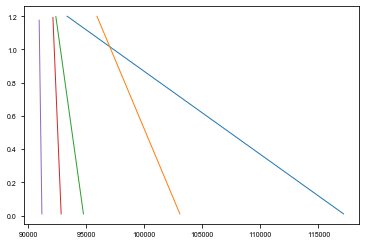

In [5]:
for k, file in enumerate(file_list):
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    dVdt = np.gradient(data[:,2] * 1000) / np.gradient(data[:,1] / 60) # V/s -> mV/min
    
    mean = np.mean(dVdt)
    std = np.std(dVdt)
    print(speed , mean, std, std/mean)
    
    plt.plot(data[:,1], data[:,2])

## Create plot

Starting cellE_CB_LSV_3mVpermin_CB1
Starting cellF_CB_LSV_10mVpermin_CB2
Starting cellG_CB_LSV_30mVpermin_CB3
Starting cellH_CB_LSV_100mVpermin_CB4
Starting cellI_CB_LSV_300mVpermin_CB5


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


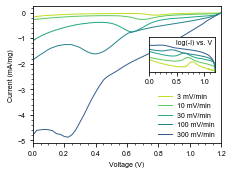

In [6]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height), nrows=1, ncols=1)

# Plot settings
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (mA/mg)')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, 1.2])

ax_inset0 = inset_axes(ax, width='100%', height='100%',
                       bbox_to_anchor=(0.6, 0.55, 0.35, 0.25),
                       bbox_transform=ax.transAxes,
                       loc='upper left')
#ax_inset0.set_xlabel('Voltage (V)', labelpad=-0.1)
ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset0.set_xlim([0, 1.2])
ax_inset0.set_ylim([1e-2, 30])

colors = cm.viridis(np.linspace(0.9, 0.3, 5))[:,0:3]

for k, file in enumerate(file_list):
    
    print(f'Starting {file.stem}')
    
    speed = int(re.findall(r'\d+', str(file).split('_')[3])[0])
    
    # Filter relevant data
    data = np.genfromtxt(file, delimiter='\t', skip_header=True)
    
    # Get first LSV sweep between UCV and end of negative sweep
    UCV = 1.2
    idx1 = np.where(data[:,2] < UCV)[0][0]
    data = data[idx1:]
    idx2 = np.where(data[:,0] == 1)[0][0]
    data = data[:idx2]
    
    # Get mass
    m = masses[k]
    
    # Get columns
    redox = data[:,0]
    time = data[:,1]
    voltage = data[:,2]
    current = data[:,3] / m
    
    # Light smoothing
    if speed < 11:
        voltage = savgol_filter(voltage, 5, 1)
        current = savgol_filter(current, 5, 1)
    
    # Plot
    ax.plot(voltage, current, color=colors[k],
            label=str(speed) + ' mV/min')
    
    ax_inset0.semilogy(voltage, -current, color=colors[k])

ax.legend(frameon=False, loc='lower right')
ax_inset0.get_yaxis().set_ticks([])

ax_inset0.annotate('log(-I) vs. V', (0.95, 0.95), xycoords='axes fraction',
                   horizontalalignment='right', verticalalignment='top')

plt.tight_layout()
plt.savefig(figpath / 'LSV.eps', bbox_inches='tight', format='eps')